 ## Проект удержания клиентов "В один клик"

<span style="font-size: 20px; font-family: Georgia;">**🎯 Цели исслдеования**</span>

- Первичная цель - **удерживать активность постоянных клиентов**


- Дополнительные цели - *извлечь полезную информацию о клиентах*, *получить прогнозы на основе существующих данных*

<span style="font-size: 20px; font-family: Georgia;">**📊 Методология**</span>

Проанализируем показатели компании за прошлый перод, получим модель, прогнозирующую снижение активности клиентов. Выделим несколько кластеров клиентов и подберём стратегии удержания для каждого. 

<span style="font-size: 18px; font-family: Georgia;">Этап 1: Анализ данных</span>

- Исследовательский анализ исторических данных

- Выявление паттернов клиентского поведения

- Определение значимых метрик и KPI

<span style="font-size: 18px; font-family: Georgia;">Этап 2: Моделирование</span>

- Модели прогнозирования оттока

- Кластерный анализ для сегментации клиентов

- Валидация моделей на тестовых данных

<span style="font-size: 18px; font-family: Georgia;">Этап 3: Рекомендации</span>

- Разработка стратегий удержания для каждого сегмента

<span style="font-size: 20px; font-family: Georgia;">📈 **Визуализация результатов**</span>

Сделаем общие глобальные выводы, предоставим *графическое подтверждение* сделанным выводам. 



In [ ]:
!pip install shap -q
!pip install -U scikit-learn -q


In [ ]:
!pip install --upgrade scikit-learn


In [ ]:
!python -m pip show scikit-learn



In [4]:
from scipy import stats as st
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error, 
    accuracy_score, recall_score, precision_score, confusion_matrix
)

from sklearn.cluster import KMeans

import shap
import os

from scipy.stats import shapiro
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score


## Загрузка данных

In [5]:
file_path = '/datasets/market_file.csv'

try:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Файл {file_path} не найден")
    
    if not file_path.lower().endswith('.csv'):
        raise ValueError("Файл должен быть в формате CSV")
    
    if not os.access(file_path, os.R_OK):
        raise PermissionError(f"Нет прав на чтение файла {file_path}")
    
    df = pd.read_csv(file_path, encoding='utf-8')

except FileNotFoundError as e:
    print(f"Ошибка: {e}")
    
except PermissionError as e:
    print(f"Ошибка доступа: {e}")
    
except pd.errors.EmptyDataError:
    print("Файл пуст")
    
except pd.errors.ParserError:
    print("Ошибка при парсинге CSV файла")
    
except Exception as e:
    print(f"Непредвиденная ошибка: {e}")

df.head(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [6]:
file_path = '/datasets/market_money.csv'

try:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Файл {file_path} не найден")
    
    if not file_path.lower().endswith('.csv'):
        raise ValueError("Файл должен быть в формате CSV")
    
    if not os.access(file_path, os.R_OK):
        raise PermissionError(f"Нет прав на чтение файла {file_path}")
    
    money = pd.read_csv(file_path, encoding='utf-8')

except FileNotFoundError as e:
    print(f"Ошибка: {e}")
    
except PermissionError as e:
    print(f"Ошибка доступа: {e}")
    
except pd.errors.EmptyDataError:
    print("Файл пуст")
    
except pd.errors.ParserError:
    print("Ошибка при парсинге CSV файла")
    
except Exception as e:
    print(f"Непредвиденная ошибка: {e}")

money.head(5)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [7]:

file_path = '/datasets/money.csv'

try:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Файл {file_path} не найден")
    
    if not file_path.lower().endswith('.csv'):
        raise ValueError("Файл должен быть в формате CSV")
    
    if not os.access(file_path, os.R_OK):
        raise PermissionError(f"Нет прав на чтение файла {file_path}")
    
    mean_money = pd.read_csv(file_path, sep=';')

except FileNotFoundError as e:
    print(f"Ошибка: {e}")
    
except PermissionError as e:
    print(f"Ошибка доступа: {e}")
    
except pd.errors.EmptyDataError:
    print("Файл пуст")
    
except pd.errors.ParserError:
    print("Ошибка при парсинге CSV файла")
    
except Exception as e:
    print(f"Непредвиденная ошибка: {e}")

mean_money.head(5)

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


In [8]:

file_path = '/datasets/market_time.csv'

try:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Файл {file_path} не найден")
    
    if not file_path.lower().endswith('.csv'):
        raise ValueError("Файл должен быть в формате CSV")
    
    if not os.access(file_path, os.R_OK):
        raise PermissionError(f"Нет прав на чтение файла {file_path}")
    
    time = pd.read_csv(file_path)

except FileNotFoundError as e:
    print(f"Ошибка: {e}")
    
except PermissionError as e:
    print(f"Ошибка доступа: {e}")
    
except pd.errors.EmptyDataError:
    print("Файл пуст")
    
except pd.errors.ParserError:
    print("Ошибка при парсинге CSV файла")
    
except Exception as e:
    print(f"Непредвиденная ошибка: {e}")

time.head(5)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


## Предобработка данных

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [10]:
mean_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [11]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [12]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [13]:
df.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [14]:
mean_money.isna().sum()

id         0
Прибыль    0
dtype: int64

In [15]:
money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [16]:
time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

In [17]:
df['id'].duplicated().sum()

0

In [18]:
mean_money['id'].duplicated().sum()

0

In [19]:
money.duplicated().sum()

0

In [20]:
time.duplicated().sum()

0

In [21]:
df.apply(lambda x: x.unique())

id                                     [215348, 215349, 215350, 215351, 215352, 21535...
Покупательская активность                                   [Снизилась, Прежний уровень]
Тип сервиса                                               [премиум, стандартт, стандарт]
Разрешить сообщать                                                             [да, нет]
Маркет_актив_6_мес                     [3.4, 4.4, 4.9, 3.2, 5.1, 3.3, 4.7, 4.2, 3.9, ...
Маркет_актив_тек_мес                                                           [5, 4, 3]
Длительность                           [121, 819, 539, 896, 1064, 762, 431, 284, 192,...
Акционные_покупки                      [0.0, 0.75, 0.14, 0.99, 0.94, 0.26, 0.23, 0.17...
Популярная_категория                   [Товары для детей, Домашний текстиль, Косметик...
Средний_просмотр_категорий_за_визит                                   [6, 4, 5, 3, 2, 1]
Неоплаченные_продукты_штук_квартал                    [2, 4, 0, 1, 3, 5, 8, 6, 9, 10, 7]
Ошибка_сервиса       

In [22]:
df['Популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [23]:
_ = {
    'премиум': 'премиум',
    'стандартт': 'стандарт',
    'стандарт': 'стандарт'
}
df['Тип сервиса'] = df['Тип сервиса'].replace(_)

In [24]:
df['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [25]:
time.apply(lambda x: x.unique())

id        [215348, 215349, 215350, 215351, 215352, 21535...
Период                    [текущий_месяц, предыдцщий_месяц]
минут     [14, 13, 10, 12, 8, 11, 6, 7, 9, 5, 15, 4, 16,...
dtype: object

In [26]:
money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [27]:
for data in [df, mean_money, money, time]:
    obj_columns = data.select_dtypes(include=['object']).columns
    data[obj_columns] = data[obj_columns].apply(lambda x: x.str.lower().str.replace(' ', '_', regex=False))


In [28]:
df['Популярная_категория'].unique()

array(['товары_для_детей', 'домашний_текстиль', 'косметика_и_аксесуары',
       'техника_для_красоты_и_здоровья', 'кухонная_посуда',
       'мелкая_бытовая_техника_и_электроника'], dtype=object)

In [29]:
money['Выручка'] = money['Выручка'].astype(float)
mean_money['Прибыль'] = mean_money['Прибыль'].str.replace(',', '.').astype(float)

### Обработка других проблем

In [30]:
df.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [31]:
mean_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [32]:
mean_money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


In [33]:
money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


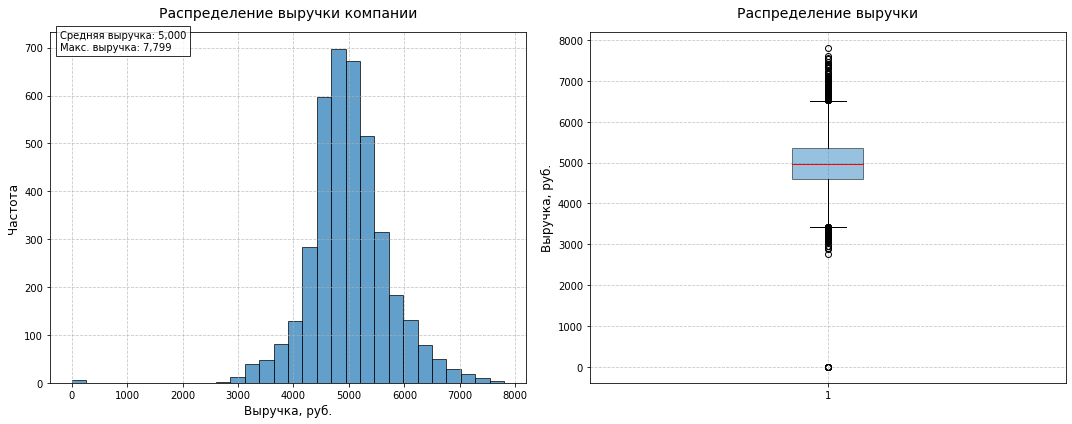

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.hist(money['Выручка'], 
         bins=30,
         edgecolor='black',
         alpha=0.7)

ax1.set_title('Распределение выручки компании', 
         fontsize=14, 
         pad=15)

ax1.set_xlabel('Выручка, руб.', fontsize=12)
ax1.set_ylabel('Частота', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)

ax1.text(0.02, 0.95, 
         f'Средняя выручка: {money["Выручка"].mean():,.0f}\nМакс. выручка: {money["Выручка"].max():,.0f}', 
         transform=ax1.transAxes,
         bbox=dict(facecolor='white', alpha=0.8))


ax2.boxplot(money['Выручка'], 
           patch_artist=True,
           boxprops=dict(facecolor='#2E86C1', alpha=0.5),
           medianprops=dict(color='red'))

ax2.set_title('Распределение выручки', 
         fontsize=14, 
         pad=15)
ax2.set_ylabel('Выручка, руб.', fontsize=12)

ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [35]:
money = money[(money['Выручка']<10000)]

In [36]:
len(money)

3899

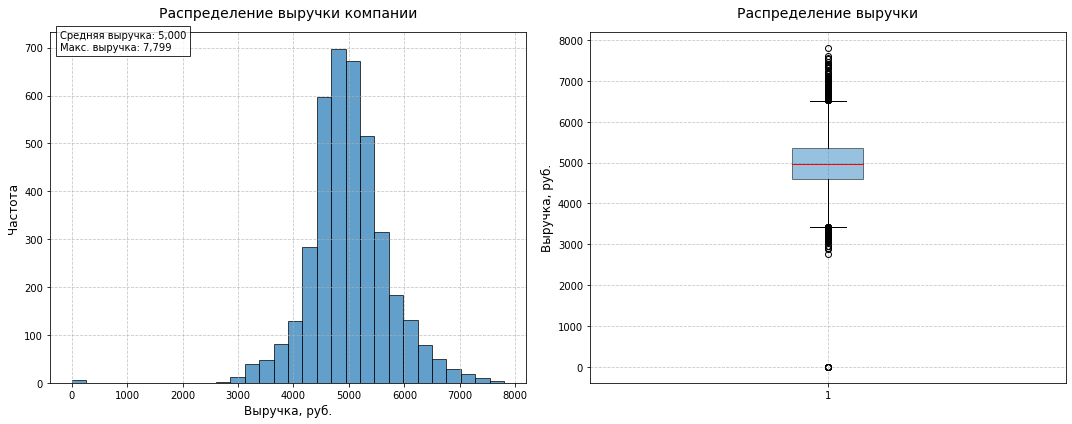

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.hist(money['Выручка'], 
         bins=30,
         edgecolor='black',
         alpha=0.7)

ax1.set_title('Распределение выручки компании', 
         fontsize=14, 
         pad=15)

ax1.set_xlabel('Выручка, руб.', fontsize=12)
ax1.set_ylabel('Частота', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)

ax1.text(0.02, 0.95, 
         f'Средняя выручка: {money["Выручка"].mean():,.0f}\nМакс. выручка: {money["Выручка"].max():,.0f}', 
         transform=ax1.transAxes,
         bbox=dict(facecolor='white', alpha=0.8))


ax2.boxplot(money['Выручка'], 
           patch_artist=True,
           boxprops=dict(facecolor='#2E86C1', alpha=0.5),
           medianprops=dict(color='red'))

ax2.set_title('Распределение выручки', 
         fontsize=14, 
         pad=15)
ax2.set_ylabel('Выручка, руб.', fontsize=12)

ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## Шаг 3. Исследовательский анализ данных

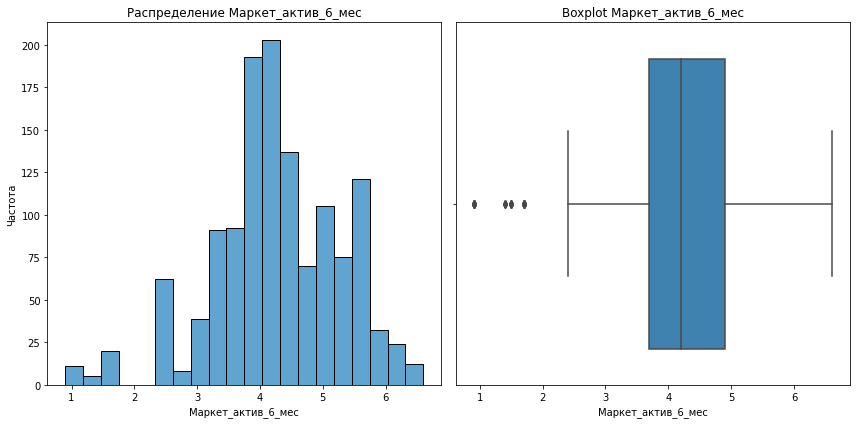

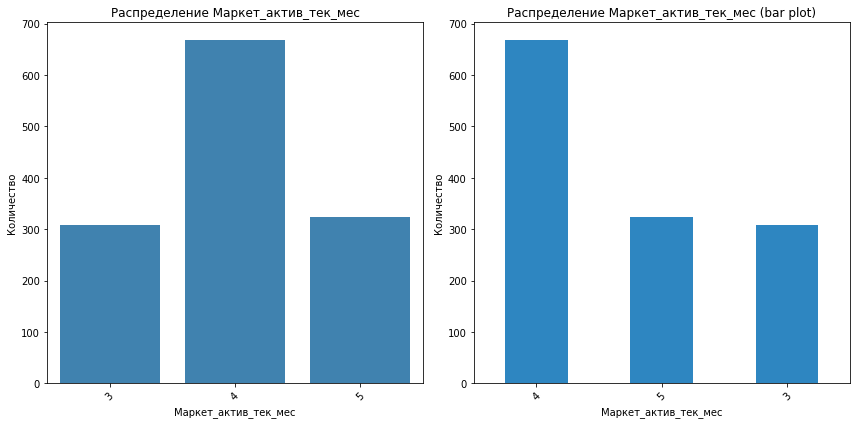

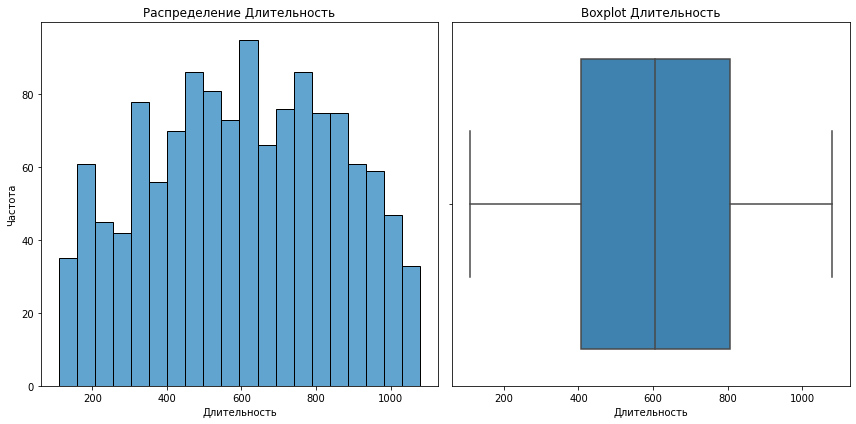

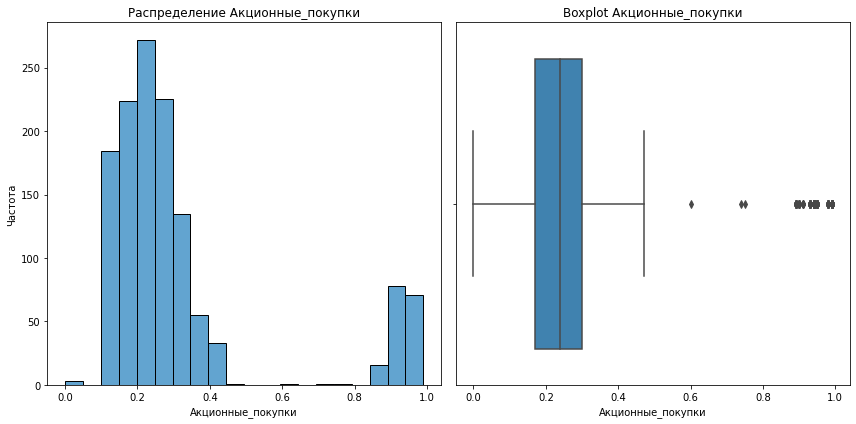

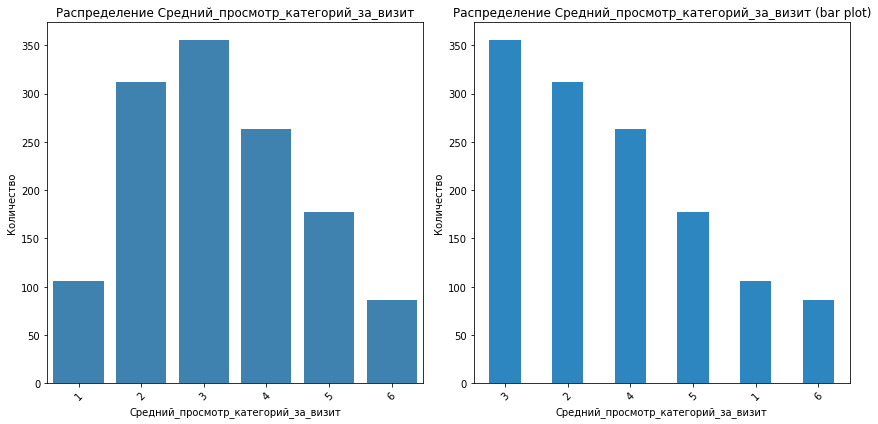

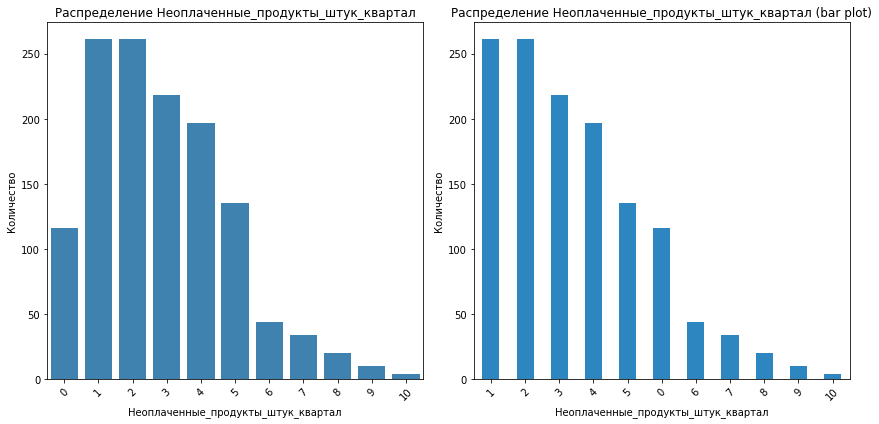

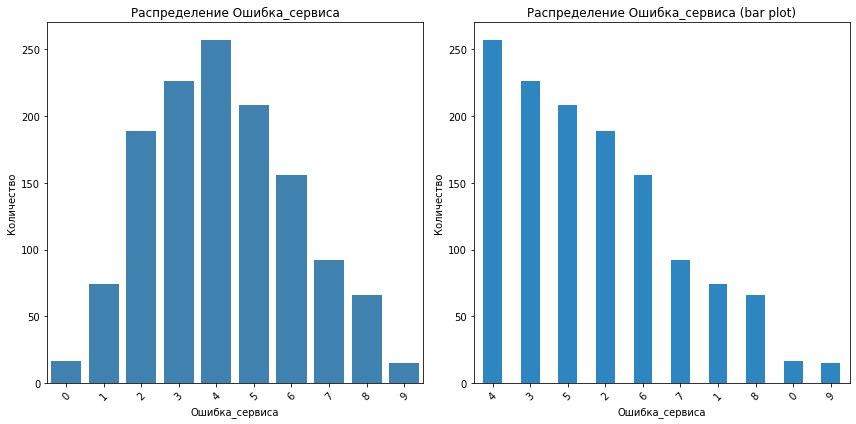

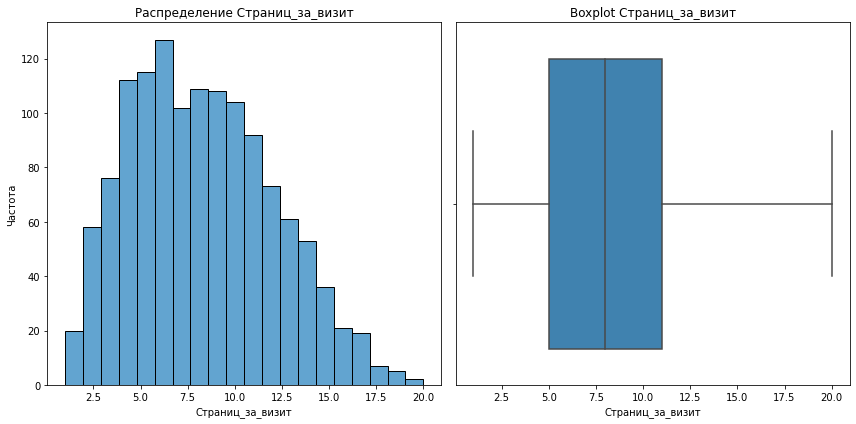

In [38]:
for column in ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
        'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал',
        'Ошибка_сервиса', 'Страниц_за_визит']:
    
    plt.figure(figsize=(12, 6))
    
    unique_values = df[column].nunique()
    

    if unique_values < 20:  
        plt.subplot(1, 2, 1)
        sns.countplot(data=df, x=column, color='#2E86C1')
        plt.title(f'Распределение {column}')
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 2, 2)
        df[column].value_counts().plot(kind='bar', color='#2E86C1')
        plt.title(f'Распределение {column} (bar plot)')
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.xticks(rotation=45)
        
    else: 
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], bins=20, color='#2E86C1')
        plt.title(f'Распределение {column}')
        plt.xlabel(column)
        plt.ylabel('Частота')
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[column], color='#2E86C1')
        plt.title(f'Boxplot {column}')
        plt.xlabel(column)
    
    plt.tight_layout()
    plt.show()


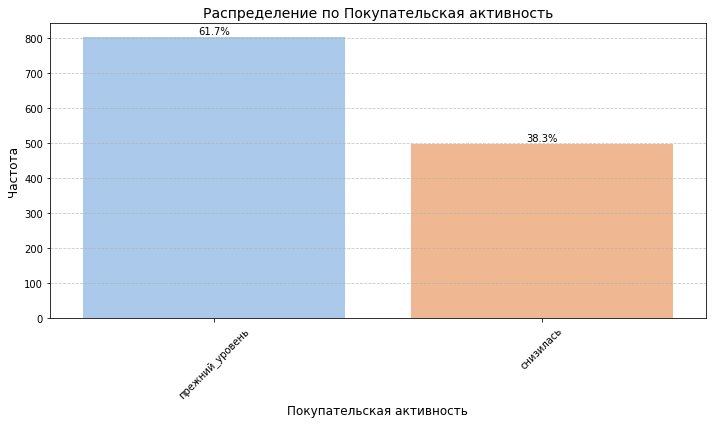

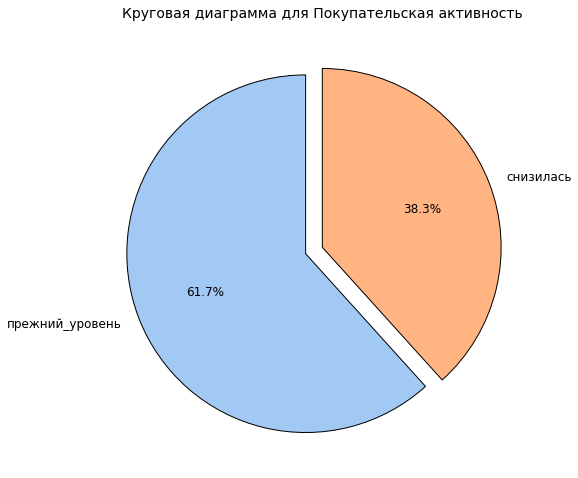

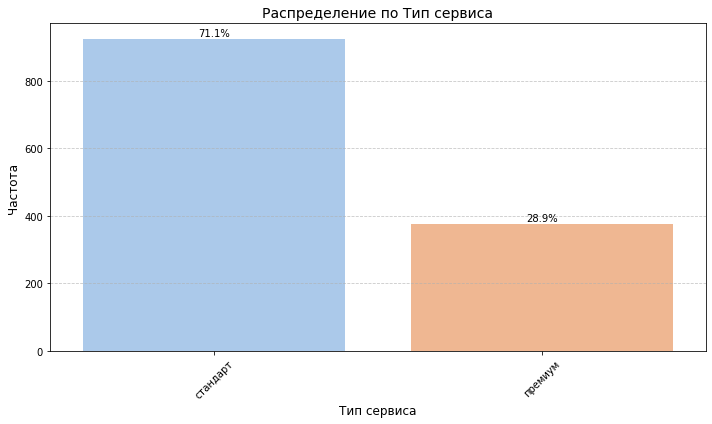

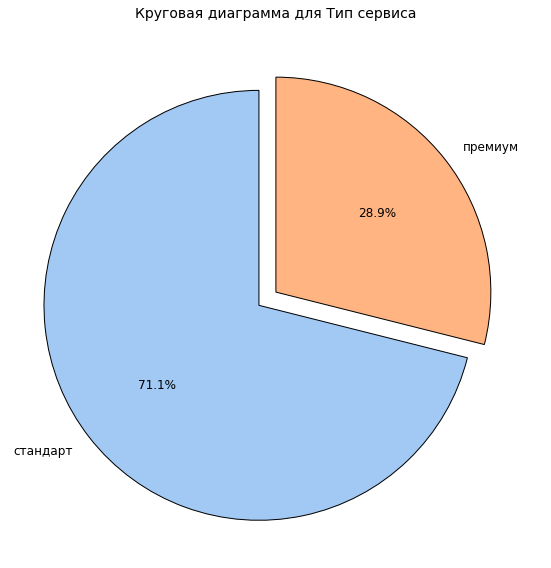

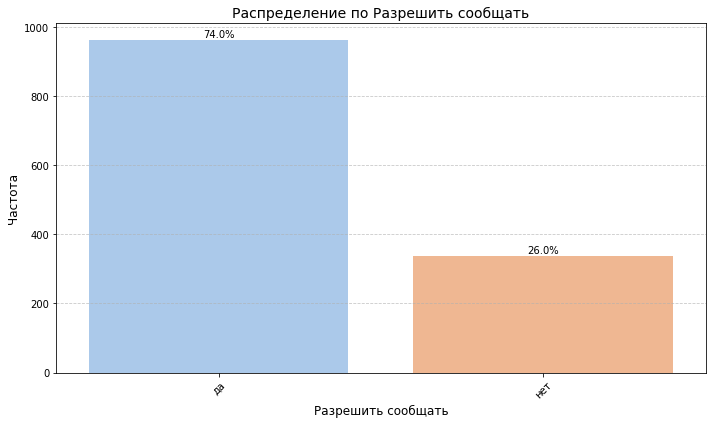

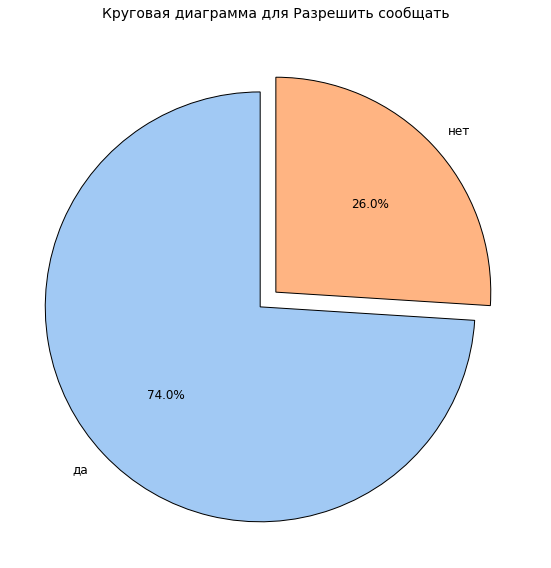

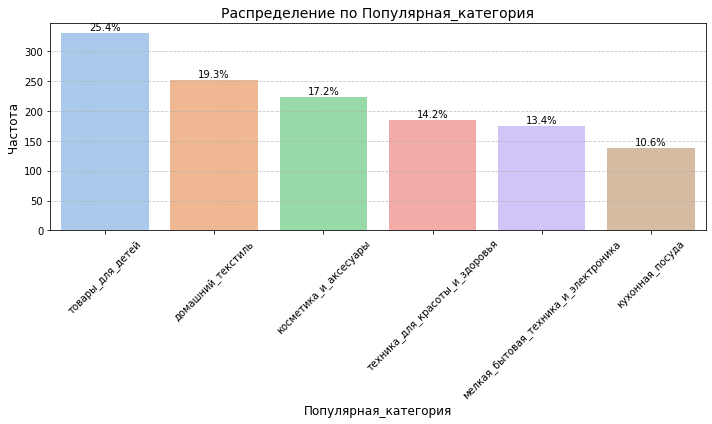

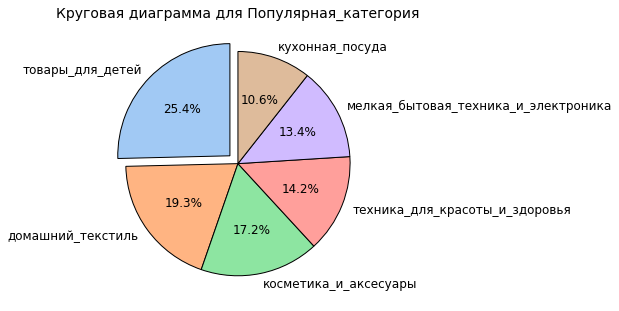

In [39]:
for column in ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']:
    plt.figure(figsize=(10, 6))
    sns.countplot(
        x=column, 
        data=df, 
        order=df[column].value_counts().index, 
        palette='pastel'
    )
    
    total = len(df[column])
    for p in plt.gca().patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        plt.gca().annotate(percentage, 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha='center', va='center', fontsize=10, color='black', xytext=(0, 6), 
                           textcoords='offset points')
    
    plt.title(f'Распределение по {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 8))
    explode = [0.1 if i == 0 else 0 for i in range(len(df[column].value_counts()))]  
    df[column].value_counts().plot.pie(
        autopct='%1.1f%%', 
        startangle=90,  
        colors=sns.color_palette('pastel'), 
        wedgeprops={'edgecolor': 'black'}, 
        explode=explode,
        textprops={'fontsize': 12}
    )
    plt.title(f'Круговая диаграмма для {column}', fontsize=14)
    plt.ylabel('')  
    plt.tight_layout()
    plt.show()


#### Промежуточые выводы

Заметим, что:
- существует подмножество покупателей, предпочитающих товары исключительно акционные,
- у большинства покупателей активность не изменилась,
- товары для женщин и детей это основная категория у большинства клиентов


## Объединение таблиц

In [40]:


mean_money_pivot = money.pivot(index='id', columns='Период', values='Выручка').reset_index()
mean_money_pivot.columns = ['id', 'Выручка_предыдущий', 'Выручка_текущий', 'Выручка_препредыдущий']
mean_money_pivot['Тренд_выручки'] = mean_money_pivot.apply(
    lambda row: (row['Выручка_текущий'] - row['Выручка_предыдущий']) / (row['Выручка_текущий'] + row['Выручка_предыдущий'])
    if (row['Выручка_текущий'] - row['Выручка_предыдущий']) != 0 else 0,
    axis=1
)
mean_money_pivot['Второй_тренд_выручки'] = mean_money_pivot.apply(
    lambda row: (row['Выручка_предыдущий'] - row['Выручка_препредыдущий']) / (row['Выручка_предыдущий'] + row['Выручка_препредыдущий'])
    if (row['Выручка_предыдущий'] - row['Выручка_препредыдущий']) != 0 else 0,
    axis=1
)
mean_money_pivot = mean_money_pivot[['id', 'Тренд_выручки', 'Второй_тренд_выручки']]

time_pivot = time.pivot(index='id', columns='Период', values='минут').reset_index()
time_pivot.columns = ['id', 'Минуты_предыдущий', 'Минуты_текущий']
time_pivot['Тренд_времени'] = time_pivot.apply(
    lambda row: (row['Минуты_текущий'] - row['Минуты_предыдущий']) / (row['Минуты_текущий'] + row['Минуты_предыдущий'])
    if (row['Минуты_текущий'] - row['Минуты_предыдущий']) != 0 else 0,
    axis=1
)
time_pivot = time_pivot[['id', 'Тренд_времени']]

data = df
data = data.merge(mean_money_pivot, on='id', how='left')
data = data.merge(time_pivot, on='id', how='left')
data.fillna(0, inplace=True)

data.head()


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Тренд_выручки,Второй_тренд_выручки,Тренд_времени
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5,0.000000,-1.000000,0.037037
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,-0.076796,0.023990,-0.090909
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,-0.061409,0.037952,0.238095
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,-0.124646,-0.035431,0.083333
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,-0.116666,-0.005565,0.157895


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [42]:
data

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Тренд_выручки,Второй_тренд_выручки,Тренд_времени
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5,0.000000,-1.000000,0.037037
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,-0.076796,0.023990,-0.090909
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,-0.061409,0.037952,0.238095
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,-0.124646,-0.035431,0.083333
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,-0.116666,-0.005565,0.157895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,прежний_уровень,стандарт,да,6.6,3,318,0.24,техника_для_красоты_и_здоровья,5,3,3,11,0.124283,-0.128211,-0.333333
1296,216644,прежний_уровень,стандарт,нет,5.1,4,454,0.21,домашний_текстиль,6,2,3,9,0.056841,-0.061892,-0.043478
1297,216645,прежний_уровень,стандарт,да,4.1,3,586,0.20,домашний_текстиль,3,2,5,7,0.016581,0.002020,0.200000
1298,216646,прежний_уровень,стандарт,да,6.3,5,645,0.12,техника_для_красоты_и_здоровья,3,3,5,7,-0.020522,-0.029721,-0.440000


In [43]:
money[money['Выручка']==0]

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [44]:
print("Клиенты с нулевой выручкой во всех периодах:")
money.groupby('id').filter(lambda x: (x['Выручка'] == 0).all())['id'].unique()


Клиенты с нулевой выручкой во всех периодах:


array([], dtype=int64)

In [45]:
data[data['Маркет_актив_6_мес']==0]

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Тренд_выручки,Второй_тренд_выручки,Тренд_времени


### Выводы

Объединили таблицы так, чтобы не создавать корреляций между параметрами будущей модели. 

Все клиенты компании имели покупательскую активность за последние 3 месяца наблюдений.

## Корреляционный анализ

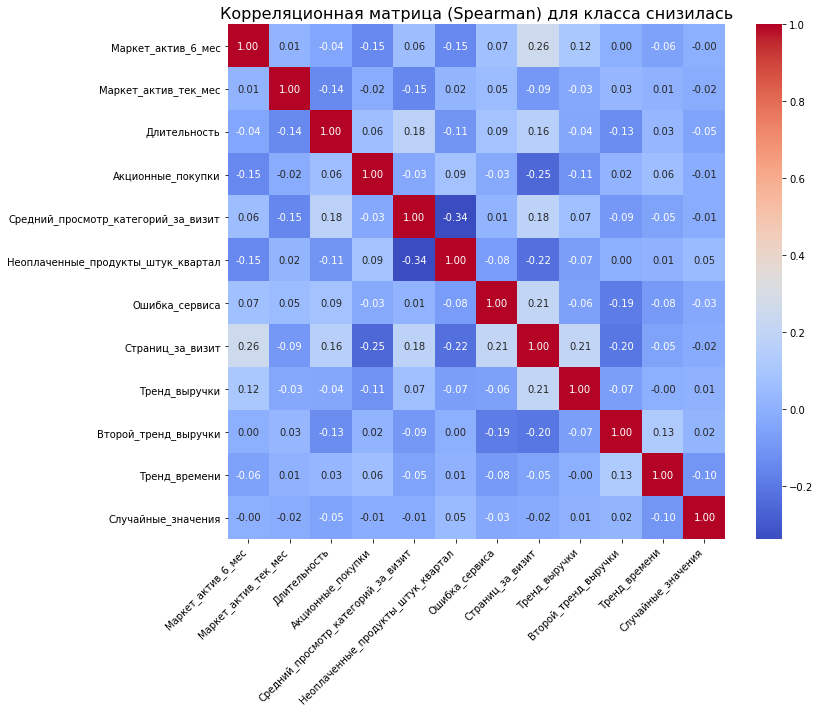

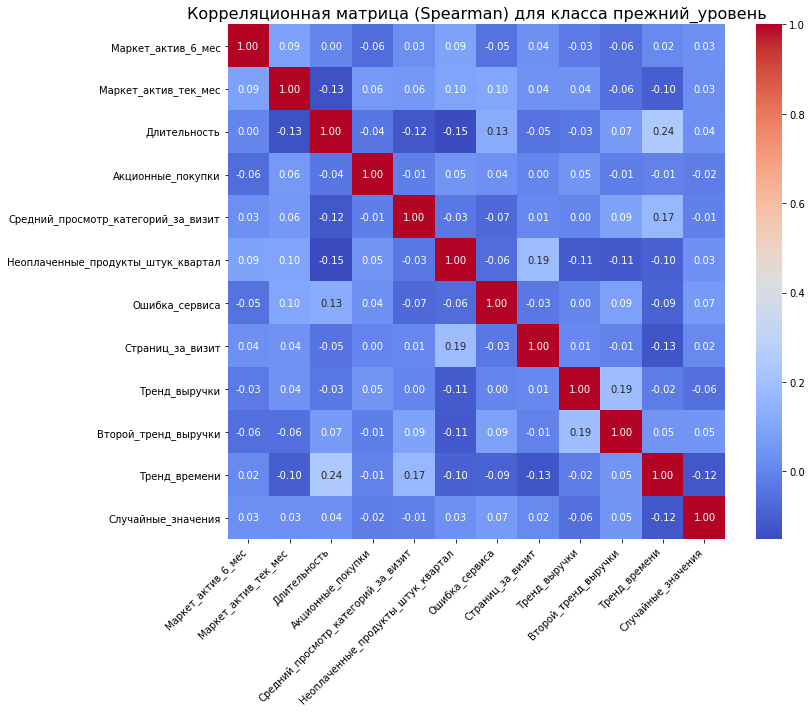

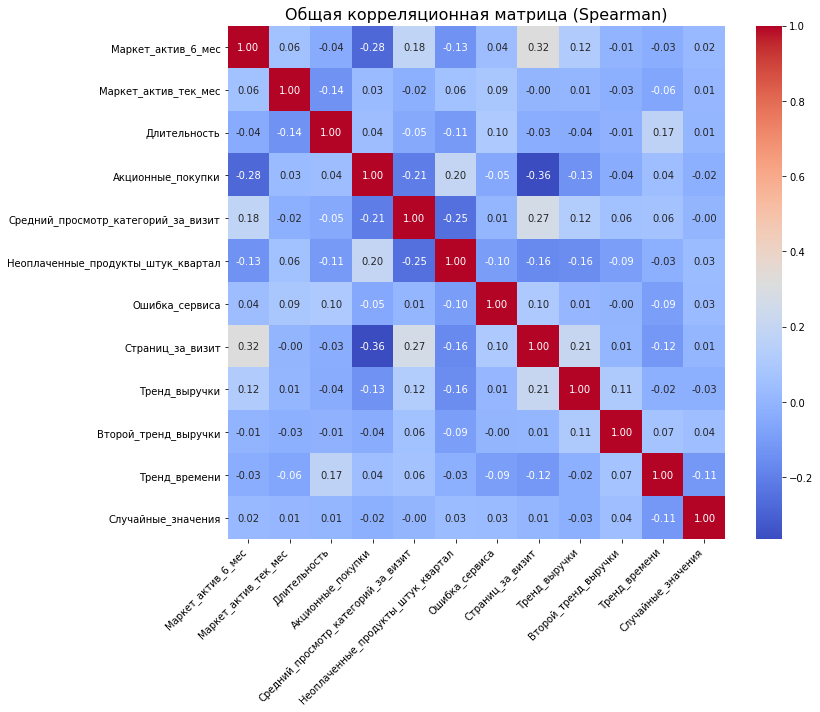

In [46]:


data_copy = data.copy()

np.random.seed(42)
data_copy['Случайные_значения'] = np.random.rand(len(data_copy))

columns_with_random = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
                       'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
                       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
                       'Страниц_за_визит', 'Тренд_выручки', 'Второй_тренд_выручки',
                       'Тренд_времени', 'Случайные_значения']

target_column = 'Покупательская активность'

for class_label in data_copy[target_column].unique():
    subset = data_copy[data_copy[target_column] == class_label]
    correlation_matrix_class = subset[columns_with_random].corr(method='spearman')
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix_class, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Корреляционная матрица (Spearman) для класса {class_label}', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

correlation_matrix_all = data_copy[columns_with_random].corr(method='spearman')
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Общая корреляционная матрица (Spearman)', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


### Выводы

В данных нету каких-то сильных корреляций, что позволяет нам использовать все наши данные для обучения моделей.
Также было проведено нормирование данных за три месяца, чтобы избежать корреляций и объединение датафреймов.

## Использование пайплайнов

In [47]:
data['id']

0       215348
1       215349
2       215350
3       215351
4       215352
         ...  
1295    216643
1296    216644
1297    216645
1298    216646
1299    216647
Name: id, Length: 1300, dtype: int64

In [48]:
X = data.drop(columns=['Покупательская активность', 'id'])
y = data['Покупательская активность']

X

,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Тренд_выручки,Второй_тренд_выручки,Тренд_времени
0,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5,0.000000,-1.000000,0.037037
1,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,-0.076796,0.023990,-0.090909
2,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,-0.061409,0.037952,0.238095
3,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,-0.124646,-0.035431,0.083333
4,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,-0.116666,-0.005565,0.157895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,стандарт,да,6.6,3,318,0.24,техника_для_красоты_и_здоровья,5,3,3,11,0.124283,-0.128211,-0.333333
1296,стандарт,нет,5.1,4,454,0.21,домашний_текстиль,6,2,3,9,0.056841,-0.061892,-0.043478
1297,стандарт,да,4.1,3,586,0.20,домашний_текстиль,3,2,5,7,0.016581,0.002020,0.200000
1298,стандарт,да,6.3,5,645,0.12,техника_для_красоты_и_здоровья,3,3,5,7,-0.020522,-0.029721,-0.440000


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

ohe_columns = [
    'Популярная_категория', 'Разрешить сообщать'
]

target_columns = [
    'Тип сервиса'
]

num_columns = [
    'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 
    'Средний_просмотр_категорий_за_визит', 
    'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Тренд_выручки', 
    'Второй_тренд_выручки',
    'Тренд_времени'
]

ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

target_pipe = Pipeline([
    ('simpleImputer_target', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('target', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
])

preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns),
        ('target', target_pipe, target_columns)
    ], 
    remainder='passthrough'
)

final_p = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('models', DecisionTreeClassifier(random_state=42))
    ]
)

param_grid = [ 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 25),
        'models__weights': ['uniform', 'distance'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [DecisionTreeClassifier(random_state=42)],
        'models__max_depth': range(2, 19),
        'models__min_samples_leaf': [2, 5, 10],
        'models__min_samples_split': [2, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=42)],
        'models__C': range(1, 6),
        'models__kernel': ['rbf', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__decision_function_shape': ['ovr', 'ovo']
    },
    {
        'models': [LogisticRegression(random_state=42, solver='saga', max_iter=45000)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__class_weight': [None, 'balanced'],
        'models__C': range(1, 6)
    }
] 


grid = GridSearchCV(final_p, param_grid=param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid.best_estimator_, grid.best_score_) 

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Популярная_категория',
                                                   'Разрешить сообщать']),
                                                 ('num', StandardScaler(),
               

In [59]:
final_p = Pipeline([
    ('preprocessor', preprocessor),
    ('models', SVC(C=1, random_state=42, probability=True))  # Added probability=True
])

final_p.fit(X_train, y_train)

y_pred = final_p.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.782258064516129

In [60]:
y_pred = final_p.predict(X_test)
accuracy_score(y_test, y_pred)

0.8461538461538461

### Выводы

🧠В ходе исследования был проведен исчерпывающий анализ различных моделей машинного обучения с оптимизацией гиперпараметров. Наилучшие результаты продемонстрировала модель k-ближайших соседей (k-NN) с параметром k=19.

📏Достигнутое значение метрики ROC-AUC = 0.89 на тестовой выборке свидетельствует о высокой эффективности модели в классификации. Это означает, что модель способна с вероятностью 89% корректно различать положительные и отрицательные классы.

## Анализ важности признаков

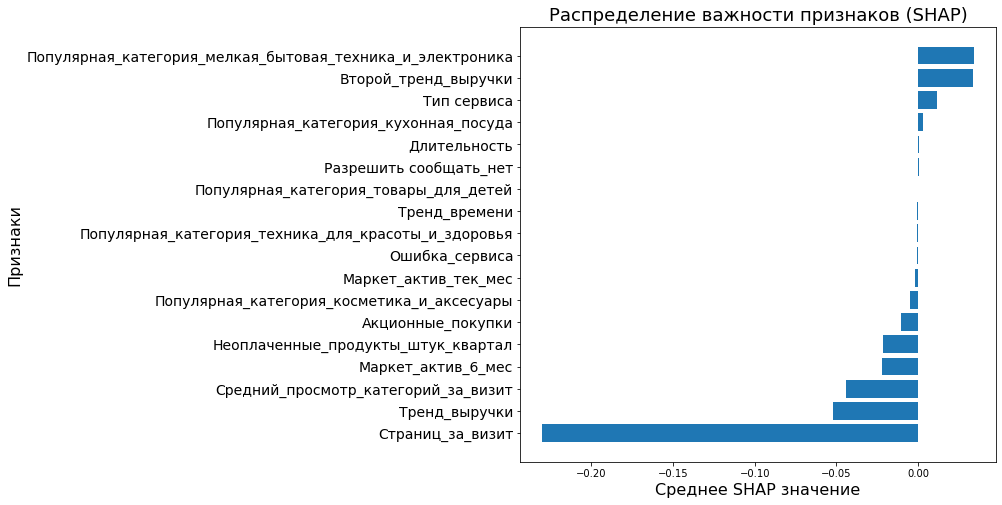

In [52]:


final_p = Pipeline(

    [

        ('preprocessor', preprocessor),

        ('models', LogisticRegression(random_state=42, solver='saga', max_iter=45000))

    ]

)

final_p.fit(X_train, y_train)

y_pred = final_p.predict(X_test)

X_train_transformed = final_p[0].transform(X_train)

X_test_transformed = final_p[0].transform(X_test)

explainer = shap.LinearExplainer(final_p['models'], X_test_transformed)

shap_values = explainer(X_test_transformed)

shap_values = explainer(X_test_transformed)


ohe_feature_names = preprocessor.named_transformers_['ohe']['ohe'].get_feature_names_out(ohe_columns)
retained_columns = num_columns + target_columns
final_columns = list(ohe_feature_names) + retained_columns 
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=final_columns)
bar_values = shap_values.values.mean(axis=0)  
feature_names = X_train_transformed_df.columns
sorted_indices = bar_values.argsort()

fig, ax = plt.subplots(figsize=(12, 8)) 
y_pos = range(len(sorted_indices))
ax.barh(y_pos, bar_values[sorted_indices])  
ax.set_yticks(y_pos)
ax.set_yticklabels(
    [feature_names[i] for i in sorted_indices], fontsize=14 
)

ax.set_xlabel('Среднее SHAP значение', fontsize=16)
ax.set_ylabel('Признаки', fontsize=16)

plt.subplots_adjust(left=0.35) 

plt.title('Распределение важности признаков (SHAP)', fontsize=18)

plt.show()




Самым важным положительным признаком для модели оказался "Второй_тренд_выручки", который показывает как выручка в прошлом месяце выросла, по сравнению с позапрошлым. Также важными оказались признаки "Популярная_категория_бытовая_техника_и_электроника" и "Популярная_категория_косметика_и_аксесуары".

Самым значимым отрицательным признаком является признак "Страниц_за_визит", также "Тренд_выручки", "Маркет_актив_6_мес" и "Средний_просмотр_категорий_за_визит".

Наименее важные для модели признаки: "Разрешить сообщать_да", "Популярная_категория_кухонная_посуда", "Популярная_категория_техника_для_красоты_и_здоровья".

### Выводы

Практическое использование наблюдений:


    Оптимизация модели:
Выявленные малозначимые признаки можно исключить для упрощения модели и сокращения времени на обучение, особенно если их значимость остается низкой при тестировании на других данных.

    Бизнес-рекомендации:
Поведение пользователей (Страниц_за_визит, Средний_просмотр_категорий_за_визит) напрямую влияет на целевой признак, возможно, выручку. Это указывает на необходимость работы над улучшением пользовательского опыта на сайте (оптимизация интерфейса, структуры категорий).


## Сегментация покупателей

In [53]:
ohe_columns = [
    'Популярная_категория', 'Разрешить сообщать', 'Покупательская активность'
]

target_columns = [
    'Тип сервиса'
]

num_columns = [
    'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 
    'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 
    'Страниц_за_визит', 'Тренд_выручки', 'Второй_тренд_выручки', 'Тренд_времени', 'Прибыль'
]

cluster = data.merge(mean_money, on='id', how='left')
cluster = cluster.drop(columns=['id', 'Ошибка_сервиса'])




ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False)
        )
    ]
)

target_pipe = Pipeline([
    ('simpleImputer_target', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('target', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
])

preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns),
        ('target', target_pipe, target_columns)
    ], 
    remainder='passthrough'
)

preprocessor.fit(cluster)
cluster_transformed = preprocessor.transform(cluster)

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(cluster_transformed)



cluster['Cluster'] = labels

ohe_feature_names = preprocessor.named_transformers_['ohe']['ohe'].get_feature_names_out(ohe_columns)

ohe_df = pd.DataFrame(
    cluster_transformed[:, :len(ohe_feature_names)], 
    columns=ohe_feature_names
)

ohe_df['Cluster'] = labels
ohe_df = ohe_df.groupby('Cluster').mean()  

ohe_summary = {}

for col in ohe_columns:
    related_ohe_cols = [c for c in ohe_feature_names if c.startswith(col)]
    ohe_summary[col] = ohe_df[related_ohe_cols]

for key, value in ohe_summary.items():
    print(f"Average OHE values for {key}:")
    print(value)
    print("\n")

cluster_analysis = cluster.groupby('Cluster').mean()
cluster_analysis


Average OHE values for Популярная_категория:
         Популярная_категория_косметика_и_аксесуары  \
Cluster                                               
0                                          0.126437   
1                                          0.165017   
2                                          0.213873   
3                                          0.169231   

         Популярная_категория_кухонная_посуда  \
Cluster                                         
0                                    0.072797   
1                                    0.075908   
2                                    0.161850   
3                                    0.102564   

         Популярная_категория_мелкая_бытовая_техника_и_электроника  \
Cluster                                                              
0                                                 0.195402           
1                                                 0.122112           
2                                                

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Страниц_за_визит,Тренд_выручки,Второй_тренд_выручки,Тренд_времени,Прибыль
Cluster,,,,,,,,,,,
0,4.546360,3.954023,572.226054,0.236590,3.088123,2.386973,10.624521,-0.014718,-0.023371,-0.157920,3.126590
1,4.711551,4.369637,381.877888,0.224488,3.914191,2.735974,9.600660,0.021680,-0.049250,-0.063443,4.363498
2,3.441040,4.066474,604.832370,0.547081,2.323699,4.346821,4.291908,-0.039583,-0.030170,0.015467,4.021012
3,4.423333,3.723077,790.092308,0.247923,3.730769,1.887179,8.879487,0.003905,-0.017915,0.096866,4.272231


In [54]:
popular_category_distribution = cluster.groupby('Cluster')['Популярная_категория'].value_counts(normalize=True)
popular_category_distribution = popular_category_distribution.rename('Proportion').reset_index()

for cluster_num in popular_category_distribution['Cluster'].unique():
    cluster_data = popular_category_distribution[popular_category_distribution['Cluster'] == cluster_num]
    print(f"\nКластер {cluster_num}:")
    print(cluster_data[['Популярная_категория', 'Proportion']])



Кластер 0:
                   Популярная_категория  Proportion
0                      товары_для_детей    0.218391
1  мелкая_бытовая_техника_и_электроника    0.195402
2        техника_для_красоты_и_здоровья    0.195402
3                     домашний_текстиль    0.191571
4                 косметика_и_аксесуары    0.126437
5                       кухонная_посуда    0.072797

Кластер 1:
                    Популярная_категория  Proportion
6                       товары_для_детей    0.293729
7                      домашний_текстиль    0.191419
8                  косметика_и_аксесуары    0.165017
9         техника_для_красоты_и_здоровья    0.151815
10  мелкая_бытовая_техника_и_электроника    0.122112
11                       кухонная_посуда    0.075908

Кластер 2:
                    Популярная_категория  Proportion
12                      товары_для_детей    0.271676
13                 косметика_и_аксесуары    0.213873
14                     домашний_текстиль    0.199422
15               

In [55]:
cluster.groupby('Cluster')['Покупательская активность'].count()

Cluster
0    261
1    303
2    346
3    390
Name: Покупательская активность, dtype: int64

### Анализ важности признаков для каждого кластера

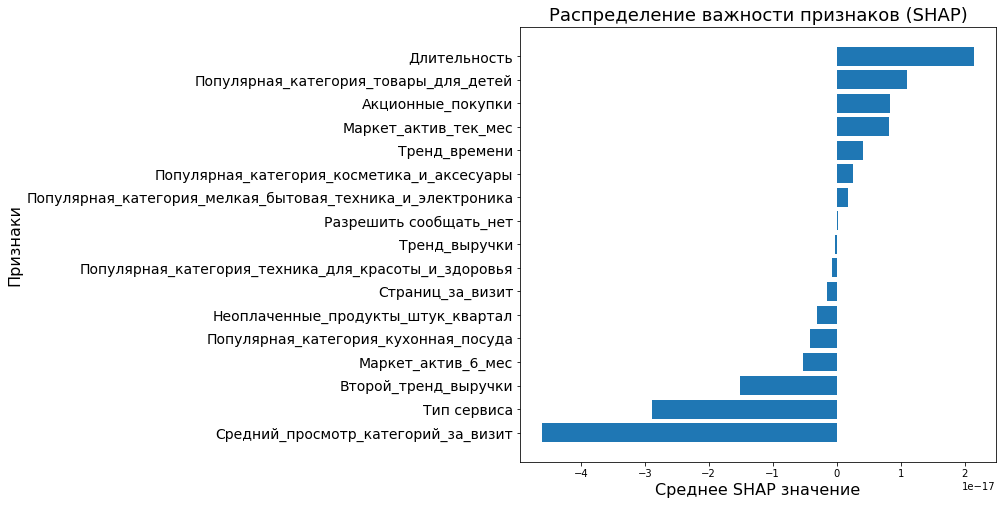

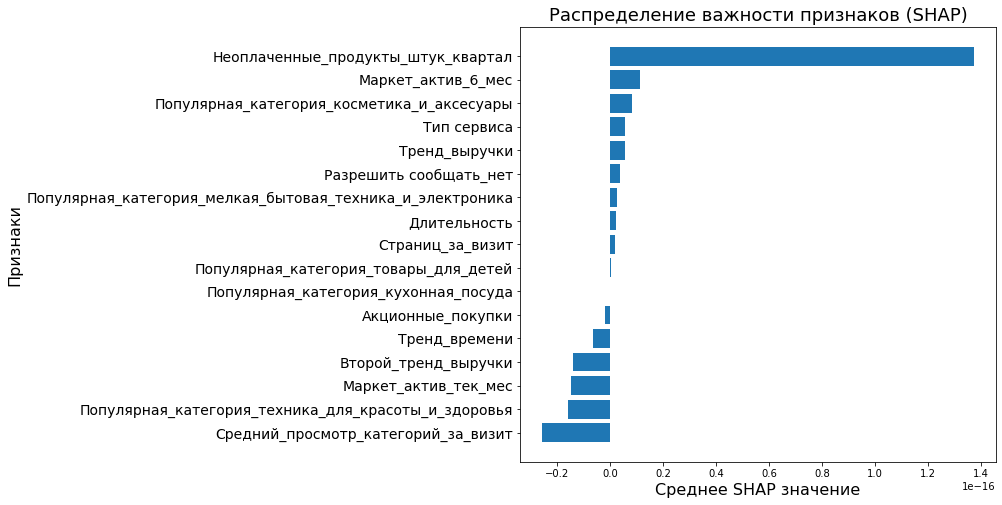

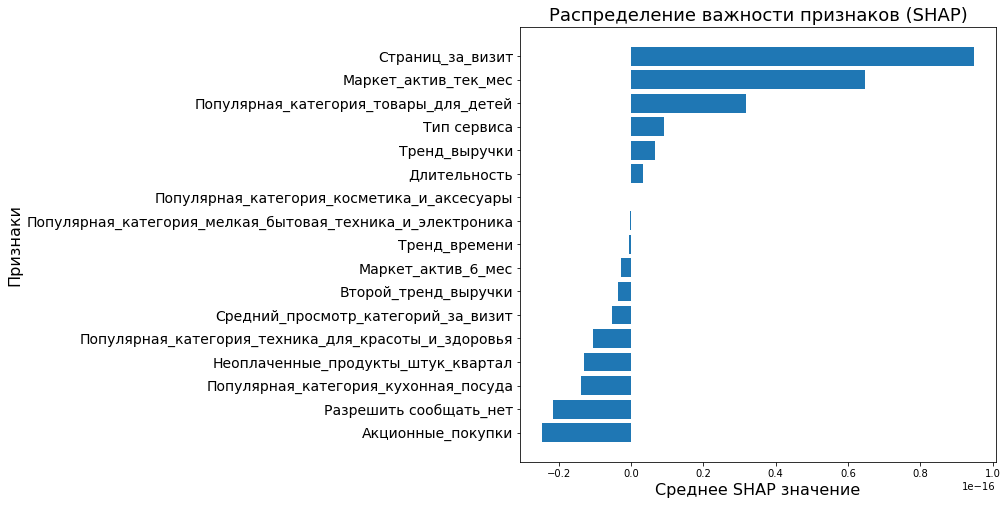

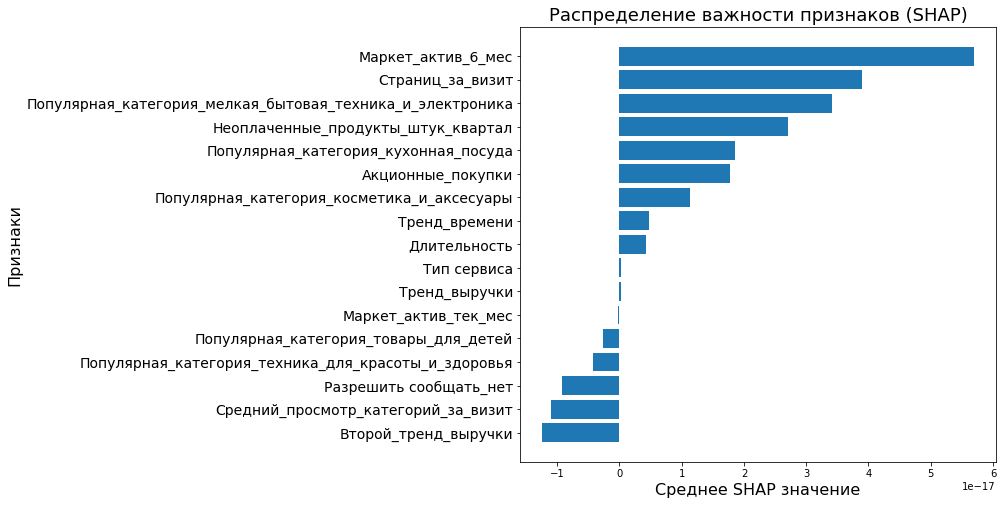

In [56]:
ohe_columns = [
    'Популярная_категория', 'Разрешить сообщать'
]

target_columns = [
    'Тип сервиса'
]

num_columns = [
    'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 
    'Средний_просмотр_категорий_за_визит', 
    'Неоплаченные_продукты_штук_квартал', 'Страниц_за_визит', 'Тренд_выручки', 
    'Второй_тренд_выручки',
    'Тренд_времени'
]

preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns),
        ('target', target_pipe, target_columns)
    ], 
    remainder='passthrough'
)

final_p = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('models', LogisticRegression(random_state=42, solver='saga', max_iter=45000))
    ]
)

for cluster_number in range(4):
    
    X = cluster[cluster['Cluster']==cluster_number].drop(columns=['Покупательская активность', 'Прибыль', 'Cluster'])
    y = cluster[cluster['Cluster']==cluster_number]['Покупательская активность']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    final_p.fit(X_train, y_train)

    y_pred = final_p.predict(X_test)

    X_train_transformed = final_p[0].transform(X_train)

    X_test_transformed = final_p[0].transform(X_test)

    explainer = shap.LinearExplainer(final_p['models'], X_test_transformed)

    shap_values = explainer(X_test_transformed)

    shap_values = explainer(X_test_transformed)


    ohe_feature_names = preprocessor.named_transformers_['ohe']['ohe'].get_feature_names_out(ohe_columns)
    retained_columns = num_columns + target_columns
    final_columns = list(ohe_feature_names) + retained_columns 
    X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=final_columns)
    bar_values = shap_values.values.mean(axis=0)  
    feature_names = X_train_transformed_df.columns
    sorted_indices = bar_values.argsort()

    fig, ax = plt.subplots(figsize=(12, 8)) 
    y_pos = range(len(sorted_indices))
    ax.barh(y_pos, bar_values[sorted_indices])  
    ax.set_yticks(y_pos)
    ax.set_yticklabels(
        [feature_names[i] for i in sorted_indices], fontsize=14 
    )

    ax.set_xlabel('Среднее SHAP значение', fontsize=16)
    ax.set_ylabel('Признаки', fontsize=16)

    plt.subplots_adjust(left=0.35) 

    plt.title('Распределение важности признаков (SHAP)', fontsize=18)

    plt.show()




### Выводы

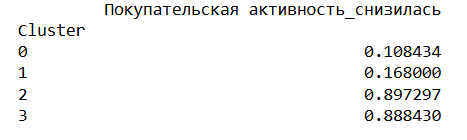 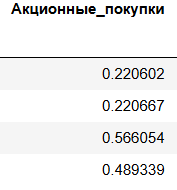
Кластер 0 и Кластер 1: Более стабильные и активные клиенты с минимумом просрочек. 

Кластер 2 и Кластер 3: Клиенты с высокой чувствительностью к скидкам и снижением активности(особенно кластер 2). Требуют индивидуального подхода с элементами реактивации и удержания активности

<span style="font-size: 20px; font-family: Georgia;">**Рекомендации**</span>

| Кластер | Признаки сохранения активности | Признаки снижения активности |
|---------|------------------------|------------------------|
| 0<br>Лояльные | • недавняя активность<br>• популярная категория (детские товары, электроника, красота и здоровье)<br>• длительность регистрации<br>• количество страниц за визит | • рост покупок в прошлом месяце по сравнению с позапрошлым<br>• доля акционных товаров |
| 1<br>Стабильные | • рост покупок в этом месяце по сравнению с прошлым<br>• доля акционных товаров | • рост покупок в прошлом месяце по сравнению с позапрошлым<br>• просмотр категорий за визит<br>• длительность регистрации|
| 2<br>Уходящие лояльные | • количество страниц за визит<br>• длительность регистрации<br>• популярная категория (детские товары, электроника, красота и здоровье)<br>• доля акционных товаров | • активность за 6 последних месяцев |
| 3<br>Нестабильные | • длительность регистрации<br>• доля акционных товаров | • количество страниц за визит<br>• рост покупок в прошлом месяце по сравнению с позапрошлым<br>• количество неоплаченных товаров<br>• стандартный сервис<br>• рост покупок в этом месяце по сравнению с прошлым<br>• активность за 6 последних месяцев|

<span style="font-size: 16px; font-family: Georgia;">**Для лояльных клиентов**</span>

    - Персонализированные предложения: Периодически предлагать товары из популярных категорий на основе их прошлых покупок.
    - Оптимизация программы лояльности: Запросить участие в специальных акциях для постоянных клиентов.
    - Информирование: Организовать автоматические e-mail или push-уведомления о появлении нового ассортимента в их любимых категориях.
    - Ценность вне скидок: Учитывая высокую стабильность, можно сосредоточиться на уникальных предложениях, например, услугах премиального сервиса (быстрая доставка).

<span style="font-size: 16px; font-family: Georgia;">**Для стабильных клиентов**</span>

    - Поддерживать регулярное взаимодействие: Обновления о скидках на акции в их интересующих категориях.
    - Дополнительные бонусы за текущую активность: Например, персональные купоны, если клиент превысил определенный порог покупки.
    - Выделение уникального контента: Рекомендации на основе просмотров ранее покупавшихся товаров.
    - Контроль за снижением активности: Если покупок становится меньше, вовлекать клиента через реферальные или накопительные программы.

<span style="font-size: 16px; font-family: Georgia;">**Для уходящих лояльных клиентов**</span>

    - Акцент на акции: Предлагать эксклюзивные и временные скидки на популярные категории.
    - Частота коммуникаций: Регулярные уведомления о специальных предложениях и распродажах.
    - Стимуляция активности: Программы с «ограничением по времени», например, «Только для активных клиентов в течение 48 часов».
    - Реактивация через персонализацию: Если у клиента наблюдается спад, привлекать за счет индивидуальных предложений, например, скидка на следующий заказ при отсутствии покупок за определённый период.

<span style="font-size: 16px; font-family: Georgia;">**Для нестабильных клиентов**</span>

    - Продвигать премиум.
    - Программа возврата неактивных клиентов: Запускать кампании с промокодами на первую покупку после периода неактивности.
    - Микро-скидки: Использовать скидки в онлайн-корзинах, чтобы стимулировать завершение покупок.
    - Улучшение клиентского опыта: Удобная навигация, быстрый процесс оформления заказа, а также персонализированный интерфейс на сайте или в приложении.
    - Упрощение повторной покупки: Опция "повтори последний заказ" для клиентов, покупающих регулярно.
    - Сегментированная коммуникация: Не перегружать клиента ненужной информацией, предлагать точечные решения.


## Общий вывод

<span style="font-size: 16px; font-family: Georgia;">**📋Описание задачи**</span>

- <span style="font-size: 14px; font-family: Georgia;">**Цель**</span>: Разработать модель, прогнозирующую вероятность снижения активности клиентов интернет-магазина.
- <span style="font-size: 14px; font-family: Georgia;">**Бизнес-задача**</span>: Сегментировать клиентскую базу по показателям прибыльности и риску оттока для последующей оптимизации маркетинговых коммуникаций.

<span style="font-size: 16px; font-family: Georgia;">**🧹Предобработка**</span>

- <span style="font-size: 14px; font-family: Georgia;">**Обработка данных**</span>:
Анализ и восполнение пропущенных значений,
Выявление и устранение дубликатов,
Определение и обработка выбросов,
Стандартизация признаков

- <span style="font-size: 14px; font-family: Georgia;">**Трансформация признаков**</span>:
Нормализация числовых показателей,
Кодирование категориальных переменных,
Создание дополнительных признаков

<span style="font-size: 16px; font-family: Georgia;">**🔍Поиск лучшей модели**</span>

- <span style="font-size: 14px; font-family: Georgia;">**Методология**</span>:
Обучение и сравнение различных алгоритмов классификации,
Перебор гиперпараметров для каждой модели с использованием кросс-валидации,
Оценка моделей по метрике roc_auc

- <span style="font-size: 14px; font-family: Georgia;">**Проверка устойчивости**</span>:
Тестирование на независимой выборке,
Анализ кривых обучения для контроля переобучения,
Проверка стабильности результатов на разных семплах

<span style="font-size: 16px; font-family: Georgia;">**🏆Лучшая модель**</span>

- <span style="font-size: 14px; font-family: Georgia;">**Оптимальная модель**</span>:
Модель опорных векторов с сильной регуляризацией SVC(C=1, random_state=42),
Предварительное масштабирование данных с помощью StandardScaler

- <span style="font-size: 14px; font-family: Georgia;">**Характеристики модели**</span>:
Учет линейной и нелинейной разделимости данных,
Робастность к шуму и выбросам,
Гибкость модели для разделения сложных классов

- <span style="font-size: 14px; font-family: Georgia;">**Производительность**</span>:
Точность определения сегмента клиентов: 87%,
Точность прогноза оттока: 89% (roc_auc-мера)



### Бизнес рекомендации


    Кластеры клиентов
<span style="font-size: 18px; font-family: Georgia;">**👑Для лояльных клиентов**</span>

- <span style="font-size: 14px; font-family: Georgia;">**Персонализированные предложения**</span>: Периодически предлагать товары из популярных категорий на основе их прошлых покупок.
- <span style="font-size: 14px; font-family: Georgia;">**Оптимизация программы лояльности**</span>: Запросить участие в специальных акциях для постоянных клиентов.
- <span style="font-size: 14px; font-family: Georgia;">**Информирование**</span>: Организовать автоматические e-mail или push-уведомления о появлении нового ассортимента в их любимых категориях.
- <span style="font-size: 14px; font-family: Georgia;">**Ценность вне скидок**</span>: Учитывая высокую стабильность, можно сосредоточиться на уникальных предложениях, например, услугах премиального сервиса (быстрая доставка).

<span style="font-size: 18px; font-family: Georgia;">**🌟Для стабильных клиентов**</span>

- <span style="font-size: 14px; font-family: Georgia;">**Поддерживать регулярное взаимодействие**</span>: Обновления о скидках на акции в их интересующих категориях.
- <span style="font-size: 14px; font-family: Georgia;">**Дополнительные бонусы за текущую активность**</span>: Например, персональные купоны, если клиент превысил определенный порог покупки.
- <span style="font-size: 14px; font-family: Georgia;">**Выделение уникального контента**</span>: Рекомендации на основе просмотров ранее покупавшихся товаров.
- <span style="font-size: 14px; font-family: Georgia;">**Контроль за снижением активности**</span>: Если покупок становится меньше, вовлекать клиента через реферальные или накопительные программы.

<span style="font-size: 18px; font-family: Georgia;">**⚡Для уходящих лояльных клиентов**</span>

- <span style="font-size: 14px; font-family: Georgia;">**Акцент на акции**</span>: Предлагать эксклюзивные и временные скидки на популярные категории.
- <span style="font-size: 14px; font-family: Georgia;">**Частота коммуникаций**</span>: Регулярные уведомления о специальных предложениях и распродажах.
- <span style="font-size: 14px; font-family: Georgia;">**Стимуляция активности**</span>: Программы с «ограничением по времени», например, «Только для активных клиентов в течение 48 часов».
- <span style="font-size: 14px; font-family: Georgia;">**Реактивация через персонализацию**</span>: Если у клиента наблюдается спад, привлекать за счет индивидуальных предложений, например, скидка на следующий заказ при отсутствии покупок за определённый период.

<span style="font-size: 18px; font-family: Georgia;">**🔄Для нестабильных клиентов**</span>

- <span style="font-size: 14px; font-family: Georgia;">**Продвигать премиум.**</span>
- <span style="font-size: 14px; font-family: Georgia;">**Программа возврата неактивных клиентов**</span>: Запускать кампании с промокодами на первую покупку после периода неактивности.
- <span style="font-size: 14px; font-family: Georgia;">**Микро-скидки**</span>: Использовать скидки в онлайн-корзинах, чтобы стимулировать завершение покупок.
- <span style="font-size: 14px; font-family: Georgia;">**Улучшение клиентского опыта**</span>: Удобная навигация, быстрый процесс оформления заказа, а также персонализированный интерфейс на сайте или в приложении.
- <span style="font-size: 14px; font-family: Georgia;">**Упрощение повторной покупки**</span>: Опция "повтори последний заказ" для клиентов, покупающих регулярно.
- <span style="font-size: 14px; font-family: Georgia;">**Сегментированная коммуникация**</span>: Не перегружать клиента ненужной информацией, предлагать точечные решения.

<span style="font-size: 20px; font-family: Georgia;">**📊Важные признаки сохранения/снижения активности**</span>

<span style="font-size: 14px; font-family: Georgia;">**Популярная категория**</span>: Наиболее востребованы товары для детей, косметика и бытовая электроника. Эти категории нужно активно продвигать.

<span style="font-size: 14px; font-family: Georgia;">**Страницы за визит**</span>: Наибольшее значение для предсказания активности. Увеличение вовлеченности через удобный интерфейс и расширенный каталог критично.

<span style="font-size: 14px; font-family: Georgia;">**Акционные покупки**</span>: Чувствительность к скидкам. Стоит фокусироваться на таргетированных акциях.
Тренд выручки и время на сайте: Удержание клиентов связано с увеличением качественного контента для изучения товаров.